In [1]:
from huggingface_hub import hf_hub_download
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

/Users/cybershiptrooper/src/interpretability/devinterp/ConceptPercolation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# iters = list(range(0, 200, 10)) + list(range(200, 1200, 20)) + list(range(1200, 10_001, 50)) + list(range(10_250, 20_001, 250))
iters = (
    list(range(0, 200, 10))
    + list(range(200, 1200, 20))
    + list(range(1200, 5_001, 50))
    + list(range(5_100, 10_001, 100))
    + list(range(10_500, 25_501, 500))
    + list(range(26_000, 99_001, 1000))
)
run_name = "3i23qszs"


In [23]:
import os
download = False
if download:
    llc_files = [hf_hub_download(
        f"cybershiptrooper/ConceptPerlocation_{run_name}_ckpts",
        repo_type="model",
        filename=f"llc/llc_output_it_{it}.pkl",
        revision="main",
        local_dir=f"./cache/{run_name}",
    ) for it in tqdm(iters)]
else:
    llc_files = [f"./cache/{run_name}/llc/llc_output_it_{it}.pkl" for it in iters]
    llc_files = [f if os.path.exists(f) else None for f in llc_files]
    llc_files = [f for f in llc_files if f is not None]

len(llc_files)

302

In [24]:
llcs = []
for file in llc_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        llcs.append(data)

In [25]:
llcs[0].keys()

dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])

In [26]:
llcs[0]["llc/trace"].shape

(5, 100)

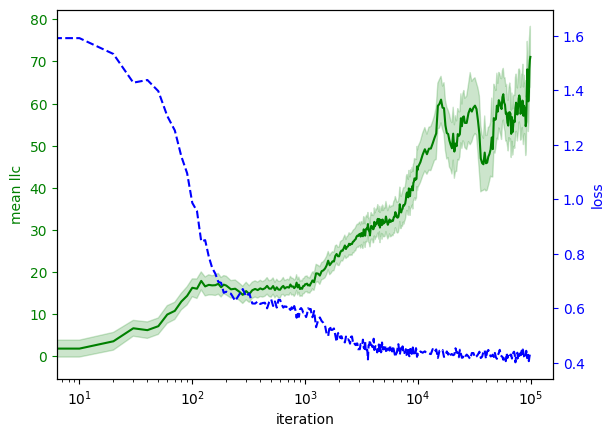

In [27]:
x = iters
y = [llc["llc/means"].mean() for llc in llcs]
y_err = [llc["llc/stds"].mean() for llc in llcs]
y_loss = [llc["init_loss"] for llc in llcs]
# plt.plot(x, y)

# plot x and y_loss with a scale on the right side
fig, ax1 = plt.subplots()
ax1.plot(x, y, 'g-')
#fill between
ax1.fill_between(x, [y[i] - y_err[i] for i in range(len(y))], [y[i] + y_err[i] for i in range(len(y))], color='g', alpha=0.2)
ax1.set_xlabel('iteration')
ax1.set_ylabel('mean llc', color='g')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(x, y_loss, 'b--')
ax2.set_ylabel('loss', color='b')
ax2.tick_params('y', colors='b')

# set x axis to log scale
plt.xscale('log')
# plt.xlim([10, 1200])

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Plot the mean LLC with fill between for error
fig.add_trace(go.Scatter(
    x=iters,
    y=[llc["llc/means"].mean() for llc in llcs],
    mode='lines+markers',
    line=dict(color='green'),
    name='Mean LLC'
))

# Fill between for error
fig.add_trace(go.Scatter(
    x=iters,
    y=[llc["llc/means"].mean() - llc["llc/stds"].mean() for llc in llcs],
    fill=None,
    mode='lines',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=iters,
    y=[llc["llc/means"].mean() + llc["llc/stds"].mean() for llc in llcs],
    fill='tonexty',
    mode='lines',
    line=dict(width=0),
    fillcolor='rgba(0,255,0,0.2)',
    showlegend=False
))

# Plot the loss on the secondary y-axis
fig.add_trace(go.Scatter(
    x=iters,
    y=[llc["init_loss"] for llc in llcs],
    mode='lines',
    line=dict(dash='dash', color='blue'),
    name='Loss',
), secondary_y=True)

# Update x-axis properties (log scale)
fig.update_xaxes(title_text="Iteration", type="log")  # Adjust 'range' to match xlim (optional)

# Update y-axis properties
fig.update_yaxes(title_text="Mean LLC", titlefont=dict(color="green"), tickfont=dict(color="green"))
fig.update_yaxes(title_text="Loss", titlefont=dict(color="blue"), tickfont=dict(color="blue"), secondary_y=True)

# Show plot
fig.show()


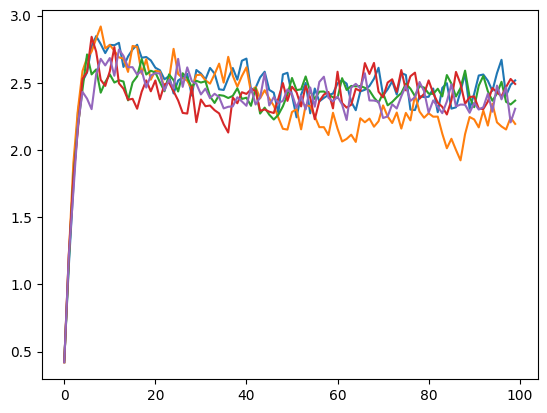

In [40]:
i_s = -15
i_e = -10
llc_traces = [llc["loss/trace"] for llc in llcs[i_s:i_e]]
# meaned_traces = llc_traces.mean(axis=1)
meaned_traces = [np.mean(llc_traces, axis=0) for llc_traces in llc_traces]

for trace in meaned_traces:
    plt.plot(trace)
    # plt.legend(iters, loc='center left', bbox_to_anchor=(1, 0.5))

In [46]:
llc_traces = [llc["loss/trace"] for llc in llcs]

2.2653089 +/- 0.31810176


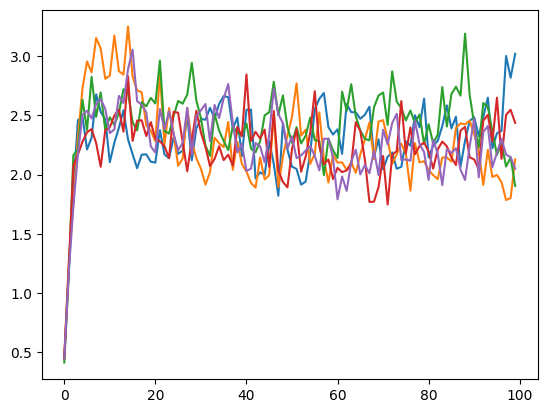

In [48]:
idx = -9
for trace in llc_traces[idx]:
    plt.plot(trace)

print(llc_traces[idx][-1].mean(), "+/-", llc_traces[idx][-1].std())

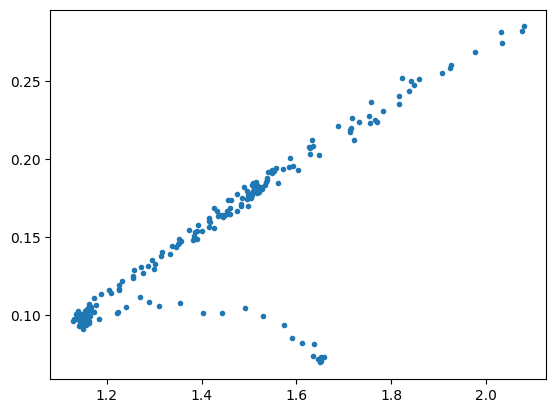

In [149]:
plt.scatter(
    [llc_traces[idx].mean(axis = -1).mean() for idx in range(len(llc_traces))],
    [llc_traces[idx].std(axis = -1).mean() for idx in range(len(llc_traces))],
    marker='.',
)